1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.signal import find_peaks


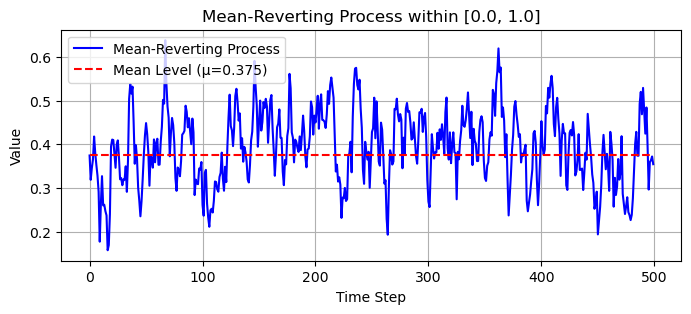

In [2]:


def mean_reverting_process(a, b, num_steps=1000, k=0.1, sigma=0.05, seed=None):

    if seed is not None:
        np.random.seed(seed)
    mu = np.random.uniform(a, b)
    X = np.zeros(num_steps)
    X[0] = mu
    
    for t in range(1, num_steps):

        X_new = X[t-1] + k * (mu - X[t-1]) + sigma * np.random.randn()
        
        if X_new < a:
            X_new = a + (a - X_new)  
        elif X_new > b:
            X_new = b - (X_new - b) 
        
        X[t] = np.clip(X_new, a, b)
    
    return X, mu

a = 0.0     
b = 1.0        
num_steps = 500
k = 0.2        # Mean reversion speed
sigma = 0.05   # Volatility
seed = 42      # For reproducibility


path, mu = mean_reverting_process(a, b, num_steps, k, sigma, seed)


time = np.arange(num_steps)

plt.figure(figsize=(8, 3))
plt.plot(time, path, label='Mean-Reverting Process', color='blue')
plt.hlines(mu, xmin=0, xmax=num_steps-1, colors='red', linestyles='dashed', label=f'Mean Level (μ={mu:.3f})')
plt.title('Mean-Reverting Process within [{}, {}]'.format(a, b))
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

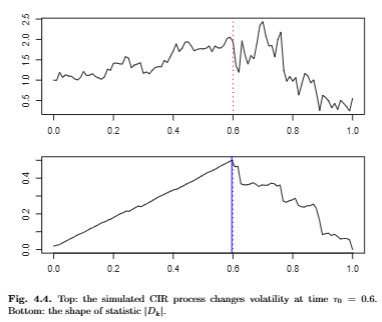

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

In [ ]:

class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx 
        self.Nt = Nt 
        self.init_state = init_state

        
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
                    x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

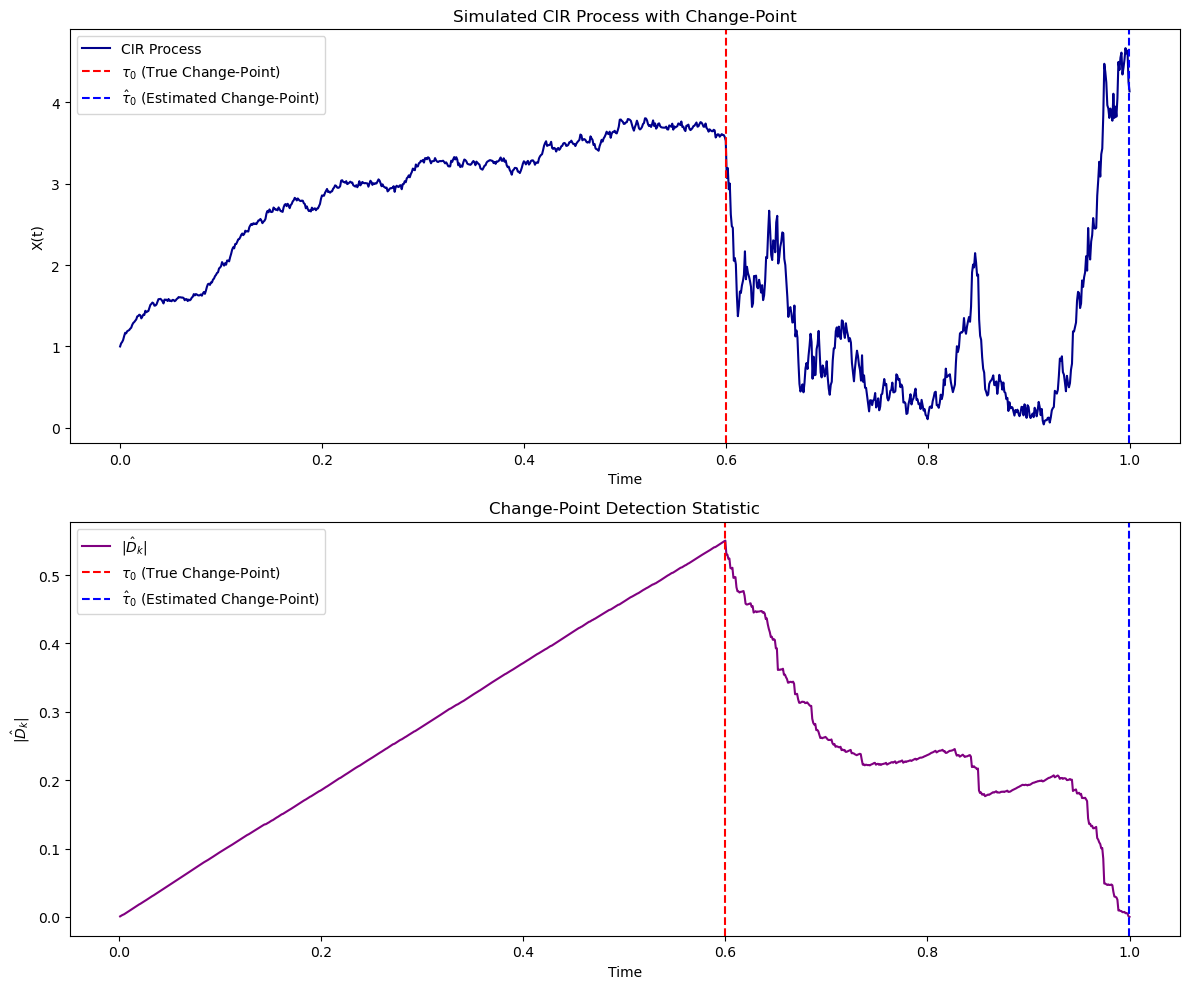

(0.6, 0.999)

In [ ]:

theta1 = 0.5        # Волатильность до точки изменения
theta2 = 5.0        # Волатильность после точки изменения
kappa = 2.0         # Скорость возврата к среднему
mu = 6.0            # Средний уровень
x0 = 1.0            # Начальное значение процесса
tau_0 = 0.6         # Истинная точка изменения
T = 1.0             # Временной горизонт
dt = 0.001          # Шаг времени
n_steps = int(T / dt)


time = np.linspace(0, T, n_steps + 1)
X = np.zeros(n_steps + 1)
X[0] = x0
np.random.seed(0)


for i in range(1, n_steps + 1):
    theta = theta1 if time[i] < tau_0 else theta2  
    dW = np.sqrt(dt) * np.random.normal()
    X[i] = X[i - 1] + kappa * (mu - X[i - 1]) * dt + theta * np.sqrt(max(X[i - 1], 0)) * dW

h_n = 0.1
Z = np.zeros(n_steps)

for i in range(n_steps):
    kernel_weights = np.exp(-((X[i] - X[:n_steps]) / h_n) ** 2)
    b_hat = np.sum(kernel_weights * (X[1:n_steps + 1] - X[:n_steps])) / (dt * np.sum(kernel_weights))
    Z[i] = (X[i + 1] - X[i] - b_hat * dt) / np.sqrt(dt)

S_k = np.cumsum(Z ** 2)
D_k = (np.arange(1, n_steps + 1) / n_steps) - (S_k / S_k[-1])
D_k_abs = np.abs(D_k)


k0_estimated = np.argmin(D_k_abs)
estimated_tau = time[k0_estimated]

fig, axs = plt.subplots(2, 1, figsize=(12, 10))


axs[0].plot(time, X, label="CIR Process", color="darkblue")
axs[0].axvline(tau_0, color="red", linestyle="--", label=r"$\tau_0$ (True Change-Point)")
axs[0].axvline(estimated_tau, color="blue", linestyle="--", label=r"$\hat{\tau}_0$ (Estimated Change-Point)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("X(t)")
axs[0].legend()
axs[0].set_title("Simulated CIR Process with Change-Point")


axs[1].plot(time[1:], D_k_abs, label=r"$|\hat{D}_k|$", color="purple")
axs[1].axvline(tau_0, color="red", linestyle="--", label=r"$\tau_0$ (True Change-Point)")
axs[1].axvline(estimated_tau, color="blue", linestyle="--", label=r"$\hat{\tau}_0$ (Estimated Change-Point)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel(r"$|\hat{D}_k|$")
axs[1].legend()
axs[1].set_title("Change-Point Detection Statistic")

plt.tight_layout()
plt.show()


tau_0, estimated_tau


---

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

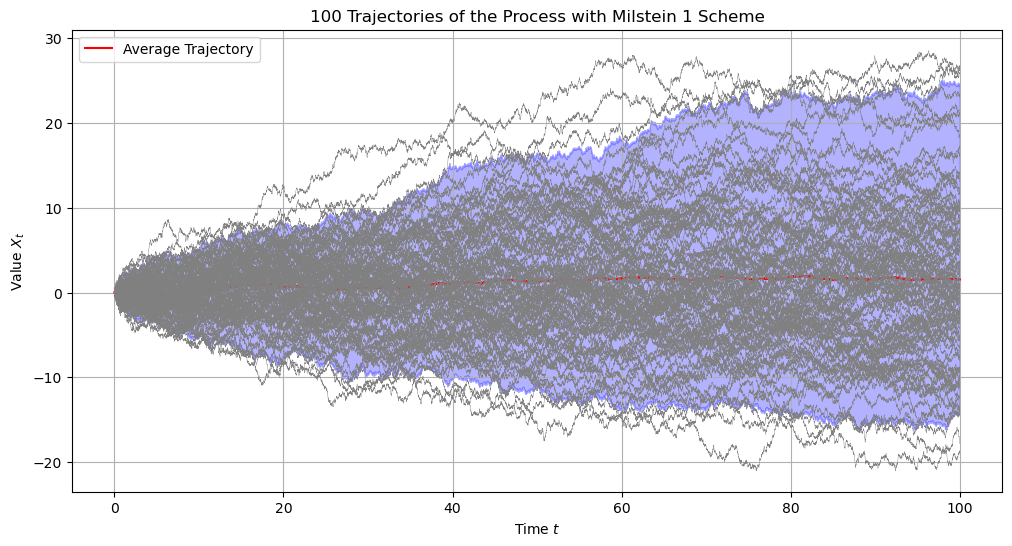

In [ ]:
class CustomProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=0):
        
        super().__init__(params, T, Nx, Nt, init_state)

    def bxt(self, t, x):

        return 0.03 * t * x - x**3

    def sigmaxt(self, x):
        return 0.1

    def sigmaxt_x(self, x):

        return 0  

T = 100               
dt = 0.01             
Nt = int(T / dt)      
x0 = 0                
Nx = 100              

process_ = CustomProcess({}, T, Nx, Nt, x0)


dW = np.random.normal(0, np.sqrt(dt), (Nt, Nx))


t_data, x_data = process_.Milstein1Solution(dW)

average_trajectory = np.mean(x_data, axis=1)
lower_bound = np.percentile(x_data, 2.5, axis=1)
upper_bound = np.percentile(x_data, 97.5, axis=1)


plt.figure(figsize=(12, 6))
plt.plot(t_data, average_trajectory, label='Average Trajectory', color='red')
plt.fill_between(t_data, lower_bound, upper_bound, alpha=0.3, color='blue')

for i in range(Nx):
    plt.plot(t_data, x_data[:, i], linewidth=0.3, color='gray')

plt.xlabel('Time $t$')
plt.ylabel('Value $X_t$')
plt.title('100 Trajectories of the Process with Milstein 1 Scheme')
plt.legend()
plt.grid(True)
plt.show()

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


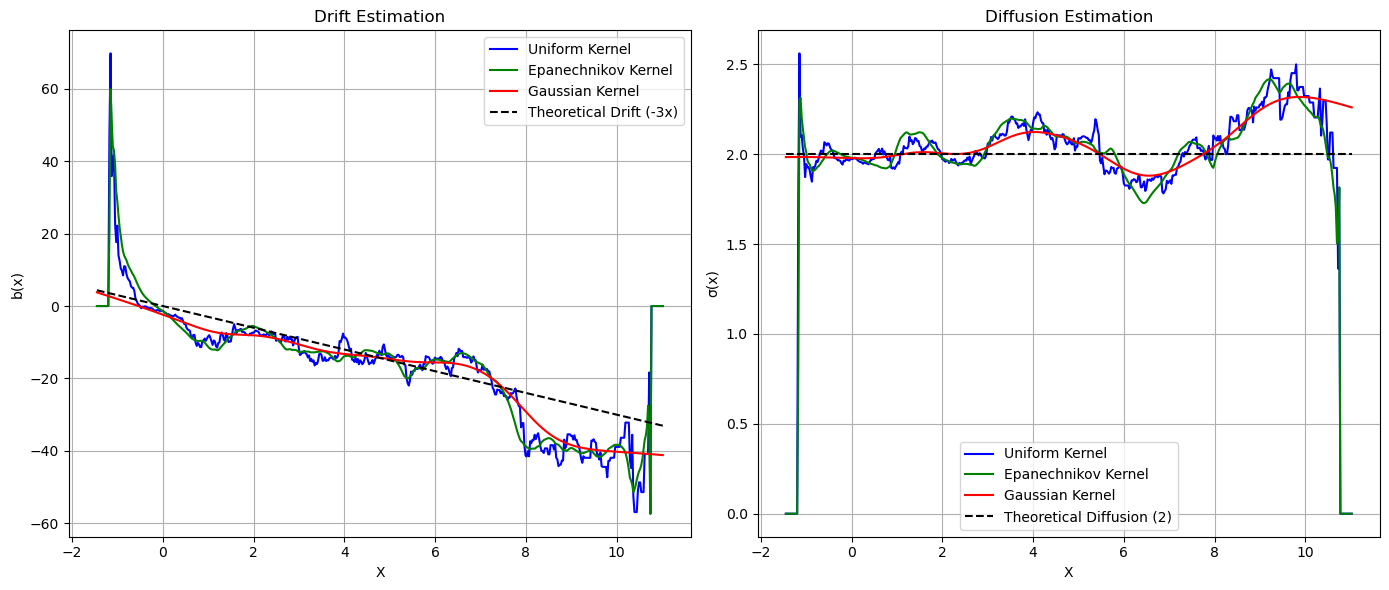

In [ ]:


theta = (0, 3, 2)  # (theta1, theta2, theta3)
X0 = 10            # Initial state
T = 1.0            # Total time
N = 1000           # Number of time steps
dt = T / N         # Time step size
time = np.linspace(0, T, N + 1)

X = np.zeros(N + 1)
X[0] = X0

for i in range(1, N + 1):
    dW = np.random.normal(0, np.sqrt(dt))
    X[i] = X[i - 1] + (theta[0] - theta[1] * X[i - 1]) * dt + theta[2] * dW



def uniform_kernel(u):
    return 0.5 * np.where(np.abs(u) <= 1, 1, 0)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * np.where(np.abs(u) <= 1, 1, 0)

def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)



def non_parametric_estimators(X, dt, h, kernel_func):

    dX = X[1:] - X[:-1]
    X_mid = X[:-1]  # X_t


    x_min, x_max = X_mid.min() - 1, X_mid.max() + 1
    x_grid = np.linspace(x_min, x_max, 500)

    b_est = np.zeros_like(x_grid)
    a_est = np.zeros_like(x_grid)

    for i, x in enumerate(x_grid):
        u = (X_mid - x) / h
        K = kernel_func(u)
        numerator_b = np.sum(K * dX) / dt
        denominator = np.sum(K)
        b_est[i] = numerator_b / denominator if denominator != 0 else 0

        numerator_a = np.sum(K * dX**2) / dt
        a_est[i] = numerator_a / denominator if denominator != 0 else 0

    return x_grid, b_est, a_est

def silverman_bandwidth(data):
    """Calculates Silverman's rule of thumb bandwidth for kernel density estimation."""
    std_dev = np.std(data)
    n = len(data)
    return 1.06 * std_dev * n ** (-1 / 5)


h_uniform = silverman_bandwidth(X)
h_epanechnikov = silverman_bandwidth(X)
h_gaussian = silverman_bandwidth(X)

x_grid_uniform, b_est_uniform, a_est_uniform = non_parametric_estimators(X, dt, h_uniform, uniform_kernel)


x_grid_epanechnikov, b_est_epanechnikov, a_est_epanechnikov = non_parametric_estimators(X, dt, h_epanechnikov, epanechnikov_kernel)


x_grid_gaussian, b_est_gaussian, a_est_gaussian = non_parametric_estimators(X, dt, h_gaussian, gaussian_kernel)

def theoretical_drift(x):
    return theta[0] - theta[1] * x 

def theoretical_diffusion(x):
    return theta[2] ** 2  


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x_grid_uniform, b_est_uniform, label='Uniform Kernel', color='blue')
plt.plot(x_grid_epanechnikov, b_est_epanechnikov, label='Epanechnikov Kernel', color='green')
plt.plot(x_grid_gaussian, b_est_gaussian, label='Gaussian Kernel', color='red')
plt.plot(x_grid_uniform, theoretical_drift(x_grid_uniform), label='Theoretical Drift (-3x)', color='black', linestyle='--')
plt.title('Drift Estimation')
plt.xlabel('X')
plt.ylabel('b(x)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_grid_uniform, np.sqrt(a_est_uniform), label='Uniform Kernel', color='blue')
plt.plot(x_grid_epanechnikov, np.sqrt(a_est_epanechnikov), label='Epanechnikov Kernel', color='green')
plt.plot(x_grid_gaussian, np.sqrt(a_est_gaussian), label='Gaussian Kernel', color='red')
plt.plot(x_grid_uniform, np.sqrt(theoretical_diffusion(x_grid_uniform)) * np.ones_like(x_grid_uniform), 
         label='Theoretical Diffusion (2)', color='black', linestyle='--')
plt.title('Diffusion Estimation')
plt.xlabel('X')
plt.ylabel('σ(x)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

In [26]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

In [27]:
df = pd.read_csv('./5.csv')

In [28]:
df.rename(columns={'Unnamed: 0': 'Time', '0': 'Value'}, inplace=True)
print(df.head())


       Time     Value
0  0.000000  0.500000
1  0.003333  0.487580
2  0.006667  0.479107
3  0.010000  0.474270
4  0.013333  0.454747


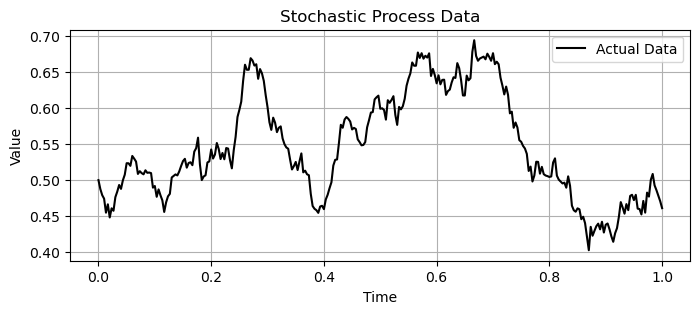

In [29]:
plt.figure(figsize=(8, 3))
plt.plot(df['Time'], df['Value'], label='Actual Data', color='black')
plt.title('Stochastic Process Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
def ou_negative_log_likelihood(params, X, dt):
    theta, mu, sigma = params
    residuals = X[1:] - X[:-1] - theta * (mu - X[:-1]) * dt
    ll = -0.5 * np.sum((residuals / (sigma * np.sqrt(dt)))**2 + np.log(2 * np.pi * (sigma**2) * dt))
    return -ll  # Negative log-likelihood


def gbm_negative_log_likelihood(params, X, dt):
    mu, sigma = params
    # Ensure no zero or negative values for GBM
    X = np.where(X <= 0, 1e-5, X)
    residuals = (np.log(X[1:] / X[:-1]) - (mu - 0.5 * sigma**2) * dt)
    ll = -0.5 * np.sum((residuals / (sigma * np.sqrt(dt)))**2 + np.log(2 * np.pi * (sigma**2) * dt))
    return -ll  # Negative log-likelihood

def cir_negative_log_likelihood(params, X, dt):
    theta, mu, sigma = params
    residuals = X[1:] - X[:-1] - theta * (mu - X[:-1]) * dt
    variance = (sigma**2) * X[:-1] * dt
    # To prevent division by zero
    variance = np.where(variance <= 0, 1e-5, variance)
    ll = -0.5 * np.sum(np.log(2 * np.pi * variance) + (residuals**2) / variance)
    return -ll  # Negative log-likelihood



In [31]:
# Extract process values
X = df['Value'].values
dt = df['Time'].diff().mean()  # Average time step

# Initial guesses
theta_init = 1.0
mu_init = np.mean(X)
sigma_init = np.std(X) * np.sqrt(2 * theta_init / (2 * theta_init))  # Rough initial guess
initial_guess_ou = [theta_init, mu_init, sigma_init]

# Optimization
result_ou = minimize(ou_negative_log_likelihood, initial_guess_ou, args=(X, dt),
                     bounds=((1e-5, None), (None, None), (1e-5, None)))

theta_est_ou, mu_est_ou, sigma_est_ou = result_ou.x
print(f"OU Estimates:\nTheta: {theta_est_ou:.4f}, Mu: {mu_est_ou:.4f}, Sigma: {sigma_est_ou:.4f}")


OU Estimates:
Theta: 4.0761, Mu: 0.5363, Sigma: 0.2189


In [32]:
# Compute log returns
log_returns = np.log(X[1:] / X[:-1])

# Initial guesses
mu_init_gbm = (np.mean(log_returns) / dt) + 0.5 * (np.std(log_returns) / np.sqrt(dt))**2
sigma_init_gbm = np.std(log_returns) / np.sqrt(dt)
initial_guess_gbm = [mu_init_gbm, sigma_init_gbm]

# Optimization
result_gbm = minimize(gbm_negative_log_likelihood, initial_guess_gbm, args=(X, dt),
                      bounds=((None, None), (1e-5, None)))

mu_est_gbm, sigma_est_gbm = result_gbm.x
print(f"GBM Estimates:\nMu: {mu_est_gbm:.4f}, Sigma: {sigma_est_gbm:.4f}")


GBM Estimates:
Mu: 0.0031, Sigma: 0.4103


In [33]:
theta_init_cir = 1.0
mu_init_cir = np.mean(X)
sigma_init_cir = np.std(X) 
initial_guess_cir = [theta_init_cir, mu_init_cir, sigma_init_cir]

# Optimization
result_cir = minimize(cir_negative_log_likelihood, initial_guess_cir, args=(X, dt),
                     bounds=((1e-5, None), (None, None), (1e-5, None)))

theta_est_cir, mu_est_cir, sigma_est_cir = result_cir.x
print(f"CIR Estimates:\nTheta: {theta_est_cir:.4f}, Mu: {mu_est_cir:.4f}, Sigma: {sigma_est_cir:.4f}")


CIR Estimates:
Theta: 4.2784, Mu: 0.5368, Sigma: 0.2980


In [34]:
# Simulation parameters
T = df['Time'].iloc[-1] - df['Time'].iloc[0]  # Total time
Nx = 1  
Nt = len(df) - 1  # Number of time steps
init_state = X[0]  # Initial state from your data


In [35]:
# Estimated parameters for OU
ou_params = [theta_est_ou, mu_est_ou, sigma_est_ou]
ou_process = OrnsteinUhlenbeckProcess(params=ou_params, T=T, Nx=Nx, Nt=Nt, init_state=init_state)
t_ou, X_ou = ou_process.EulerSolution()
X_ou = X_ou[:, 0]


In [36]:
# Estimated parameters for GBM
gbm_params = [mu_est_gbm, sigma_est_gbm]

# Create GBM process instance
gbm_process = BlackScholesMertonProcess(params=gbm_params, T=T, Nx=Nx, Nt=Nt, init_state=init_state)

# Simulate
t_gbm, X_gbm = gbm_process.EulerSolution()

# Extract the simulated values
X_gbm = X_gbm[:, 0]


In [ ]:
cir_params = [theta_est_cir, theta_est_cir, sigma_est_cir]

# tau0 = T / 2
cir_process = CoxIngersollRossProcess(params=cir_params, T=T, Nx=Nx, Nt=Nt, init_state=init_state)
t_cir, X_cir = cir_process.EulerSolution()
X_cir = X_cir[:, 0]


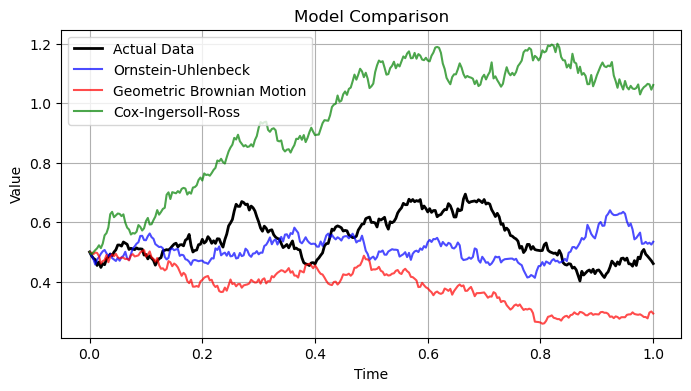

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(df['Time'], df['Value'], label='Actual Data', color='black', linewidth=2)
plt.plot(t_ou, X_ou, label='Ornstein-Uhlenbeck', color='blue', alpha=0.7)
plt.plot(t_gbm, X_gbm, label='Geometric Brownian Motion', color='red', alpha=0.7)
plt.plot(t_cir, X_cir, label='Cox-Ingersoll-Ross', color='green', alpha=0.7)
plt.title('Model Comparison')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
